In [1]:
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
data_folder = r"C:\Users\mehar\OneDrive\Desktop\DLCV\Project"

In [4]:
train_df = pd.read_csv(os.path.join(data_folder, "train.csv"))
test_df = pd.read_csv(os.path.join(data_folder, "test.csv"))
all_image_paths =   {os.path.basename(x): x for x in
                      glob(os.path.join(data_folder, 'images', '*.png'))}
train_df['path'] = train_df['Image Index'].map(all_image_paths.get)
test_df['path'] = test_df['Image Index'].map(all_image_paths.get)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumothorax']

In [5]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [6]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

test_gen = core_idg.flow_from_dataframe(dataframe=test_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation

train_X, train_Y = next(core_idg.flow_from_dataframe(dataframe=train_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 714))
t_x,t_y = next(train_gen)

Found 2835 validated image filenames belonging to 12 classes.
Found 714 validated image filenames belonging to 12 classes.
Found 2835 validated image filenames belonging to 12 classes.
Found 714 validated image filenames belonging to 12 classes.


In [7]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:],
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_256 (Functio  (None, 8, 8, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                6

In [9]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

In [9]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=90,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

C:\Users\mehar\AppData\Local\Temp\ipykernel_37232\1284311117.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  multi_disease_model.fit_generator(train_gen,


KeyboardInterrupt: 

In [12]:
for c_label, s_count in zip(labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 14.29%
Cardiomegaly: 3.64%
Consolidation: 5.88%
Edema: 3.22%
Effusion: 17.37%
Emphysema: 3.22%
Infiltration: 26.89%
Mass: 7.14%
No Finding: 29.27%
Nodule: 8.26%
Pleural_Thickening: 5.32%
Pneumothorax: 6.86%


In [13]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

23/23 [==============================] - 1s 35ms/step


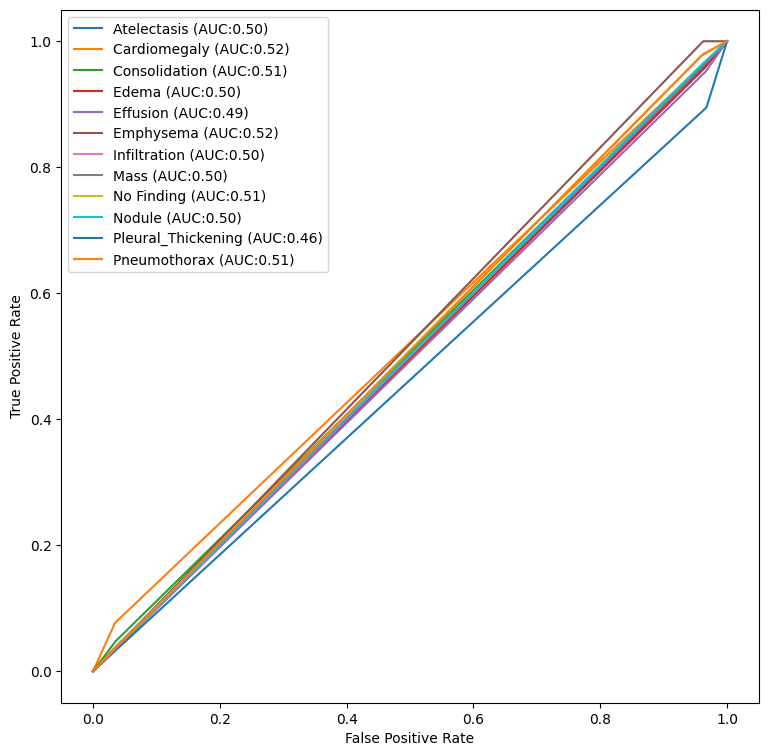

In [14]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

Optimizer Selection

In [15]:
optimizers_list = [('sgd',optimizers.SGD(learning_rate=.1) ),
                   ('sgd_momentum',optimizers.SGD(learning_rate=.1, momentum=.9) ),
                   ('adagrad',optimizers.Adagrad()),
                   ('adadelta',optimizers.Adadelta()),
                   ('adam', optimizers.Adam())
                  ]

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5)

callbacks_list = [early, ModelCheckpoint( filepath=weight_path, monitor='val_loss', mode='min', save_best_only=True )]

C:\Users\mehar\AppData\Local\Temp\ipykernel_27800\3493546153.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = multi_disease_model.fit_generator(train_gen,


Epoch 1/50
45/45 [==============================] - 17s 341ms/step - loss: 0.3577 - binary_accuracy: 0.8754 - mae: 0.1901 - val_loss: 0.3201 - val_binary_accuracy: 0.8905 - val_mae: 0.1607
Epoch 2/50
45/45 [==============================] - 15s 336ms/step - loss: 0.3409 - binary_accuracy: 0.8821 - mae: 0.1864 - val_loss: 0.3292 - val_binary_accuracy: 0.8905 - val_mae: 0.1499
Epoch 3/50
45/45 [==============================] - 15s 335ms/step - loss: 0.3395 - binary_accuracy: 0.8817 - mae: 0.1872 - val_loss: 0.3419 - val_binary_accuracy: 0.8905 - val_mae: 0.1431
Epoch 4/50
45/45 [==============================] - 18s 402ms/step - loss: 0.3362 - binary_accuracy: 0.8835 - mae: 0.1867 - val_loss: 0.3467 - val_binary_accuracy: 0.8905 - val_mae: 0.1399
Epoch 5/50
45/45 [==============================] - 15s 337ms/step - loss: 0.3258 - binary_accuracy: 0.8856 - mae: 0.1830 - val_loss: 0.3577 - val_binary_accuracy: 0.8905 - val_mae: 0.1365
Epoch 6/50
45/45 [==============================] - 15s

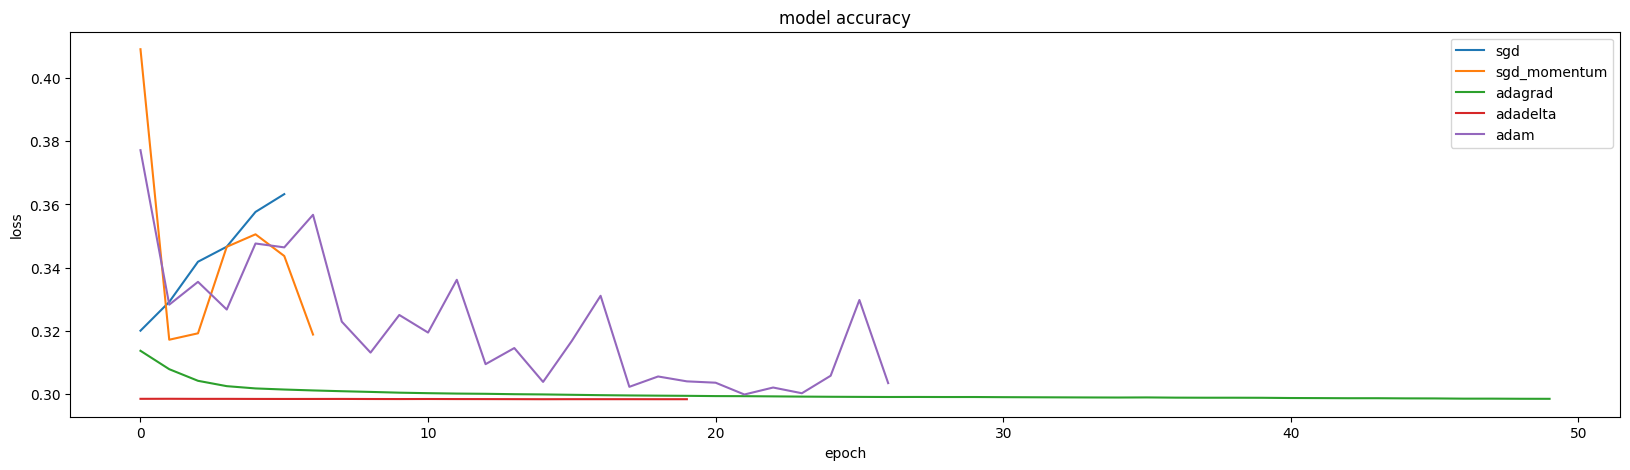

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(20,5))
for optimizer in optimizers_list:
    multi_disease_model.compile(optimizer = optimizer[1], loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

    history = multi_disease_model.fit_generator(train_gen,
                                  steps_per_epoch=45,
                                  validation_data = (test_X, test_Y),
                                  epochs = 50,
                                  callbacks = callbacks_list)


    plt.plot(history.history['val_loss'])

plt.legend([x[0] for x in optimizers_list], loc='upper right')
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig(os.path.join(data_folder,'optimizer_selection.png'), bbox_inches='tight')

In [17]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 45,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 100, 
                                  callbacks = callbacks_list)

C:\Users\mehar\AppData\Local\Temp\ipykernel_27800\334678143.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  multi_disease_model.fit_generator(train_gen,


Epoch 1/100
45/45 [==============================] - 16s 344ms/step - loss: 0.2993 - binary_accuracy: 0.8880 - mae: 0.1751 - val_loss: 0.3073 - val_binary_accuracy: 0.8876 - val_mae: 0.1698
Epoch 2/100
45/45 [==============================] - 16s 342ms/step - loss: 0.3032 - binary_accuracy: 0.8890 - mae: 0.1740 - val_loss: 0.3072 - val_binary_accuracy: 0.8852 - val_mae: 0.1637
Epoch 3/100
45/45 [==============================] - 15s 336ms/step - loss: 0.3039 - binary_accuracy: 0.8869 - mae: 0.1772 - val_loss: 0.3007 - val_binary_accuracy: 0.8915 - val_mae: 0.1695
Epoch 4/100
45/45 [==============================] - 15s 336ms/step - loss: 0.3058 - binary_accuracy: 0.8851 - mae: 0.1782 - val_loss: 0.3073 - val_binary_accuracy: 0.8899 - val_mae: 0.1557
Epoch 5/100
45/45 [==============================] - 15s 339ms/step - loss: 0.3049 - binary_accuracy: 0.8863 - mae: 0.1784 - val_loss: 0.2955 - val_binary_accuracy: 0.8917 - val_mae: 0.1658
Epoch 6/100
45/45 [==============================]

In [11]:
multi_disease_model.load_weights(weight_path)
pred_Y = multi_disease_model.predict(test_X, batch_size = 64, verbose = True)

12/12 [==============================] - 1s 98ms/step


In [12]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 14.29%, PDx: 17.45%
Cardiomegaly: Dx: 3.64%, PDx: 2.79%
Consolidation: Dx: 5.88%, PDx: 5.45%
Edema: Dx: 3.22%, PDx: 2.33%
Effusion: Dx: 17.37%, PDx: 20.93%
Emphysema: Dx: 3.22%, PDx: 2.24%
Infiltration: Dx: 26.89%, PDx: 23.84%
Mass: Dx: 7.14%, PDx: 6.38%
No Finding: Dx: 29.27%, PDx: 31.04%
Nodule: Dx: 8.26%, PDx: 8.27%
Pleural_Thickening: Dx: 5.32%, PDx: 2.86%
Pneumothorax: Dx: 6.86%, PDx: 4.28%


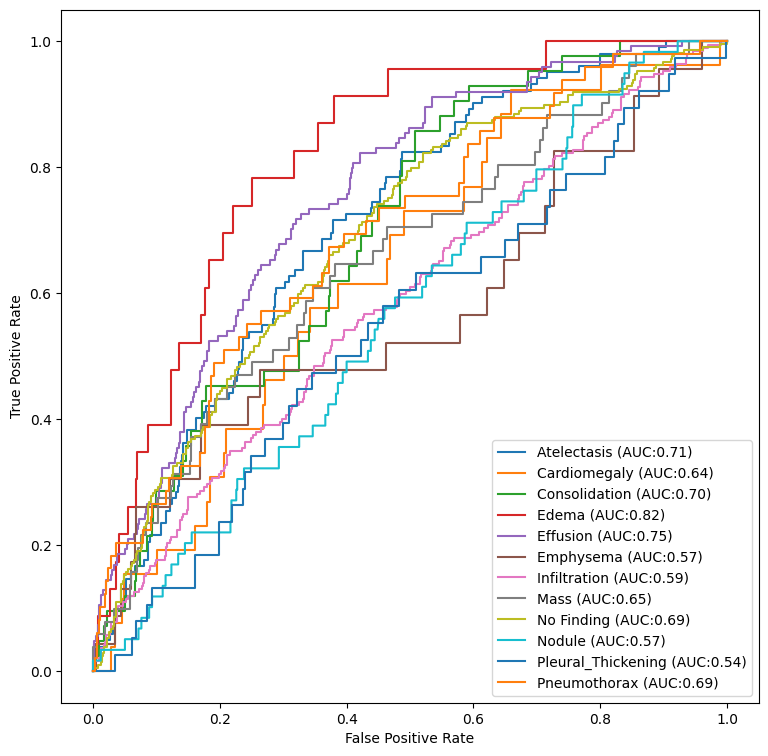

In [13]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

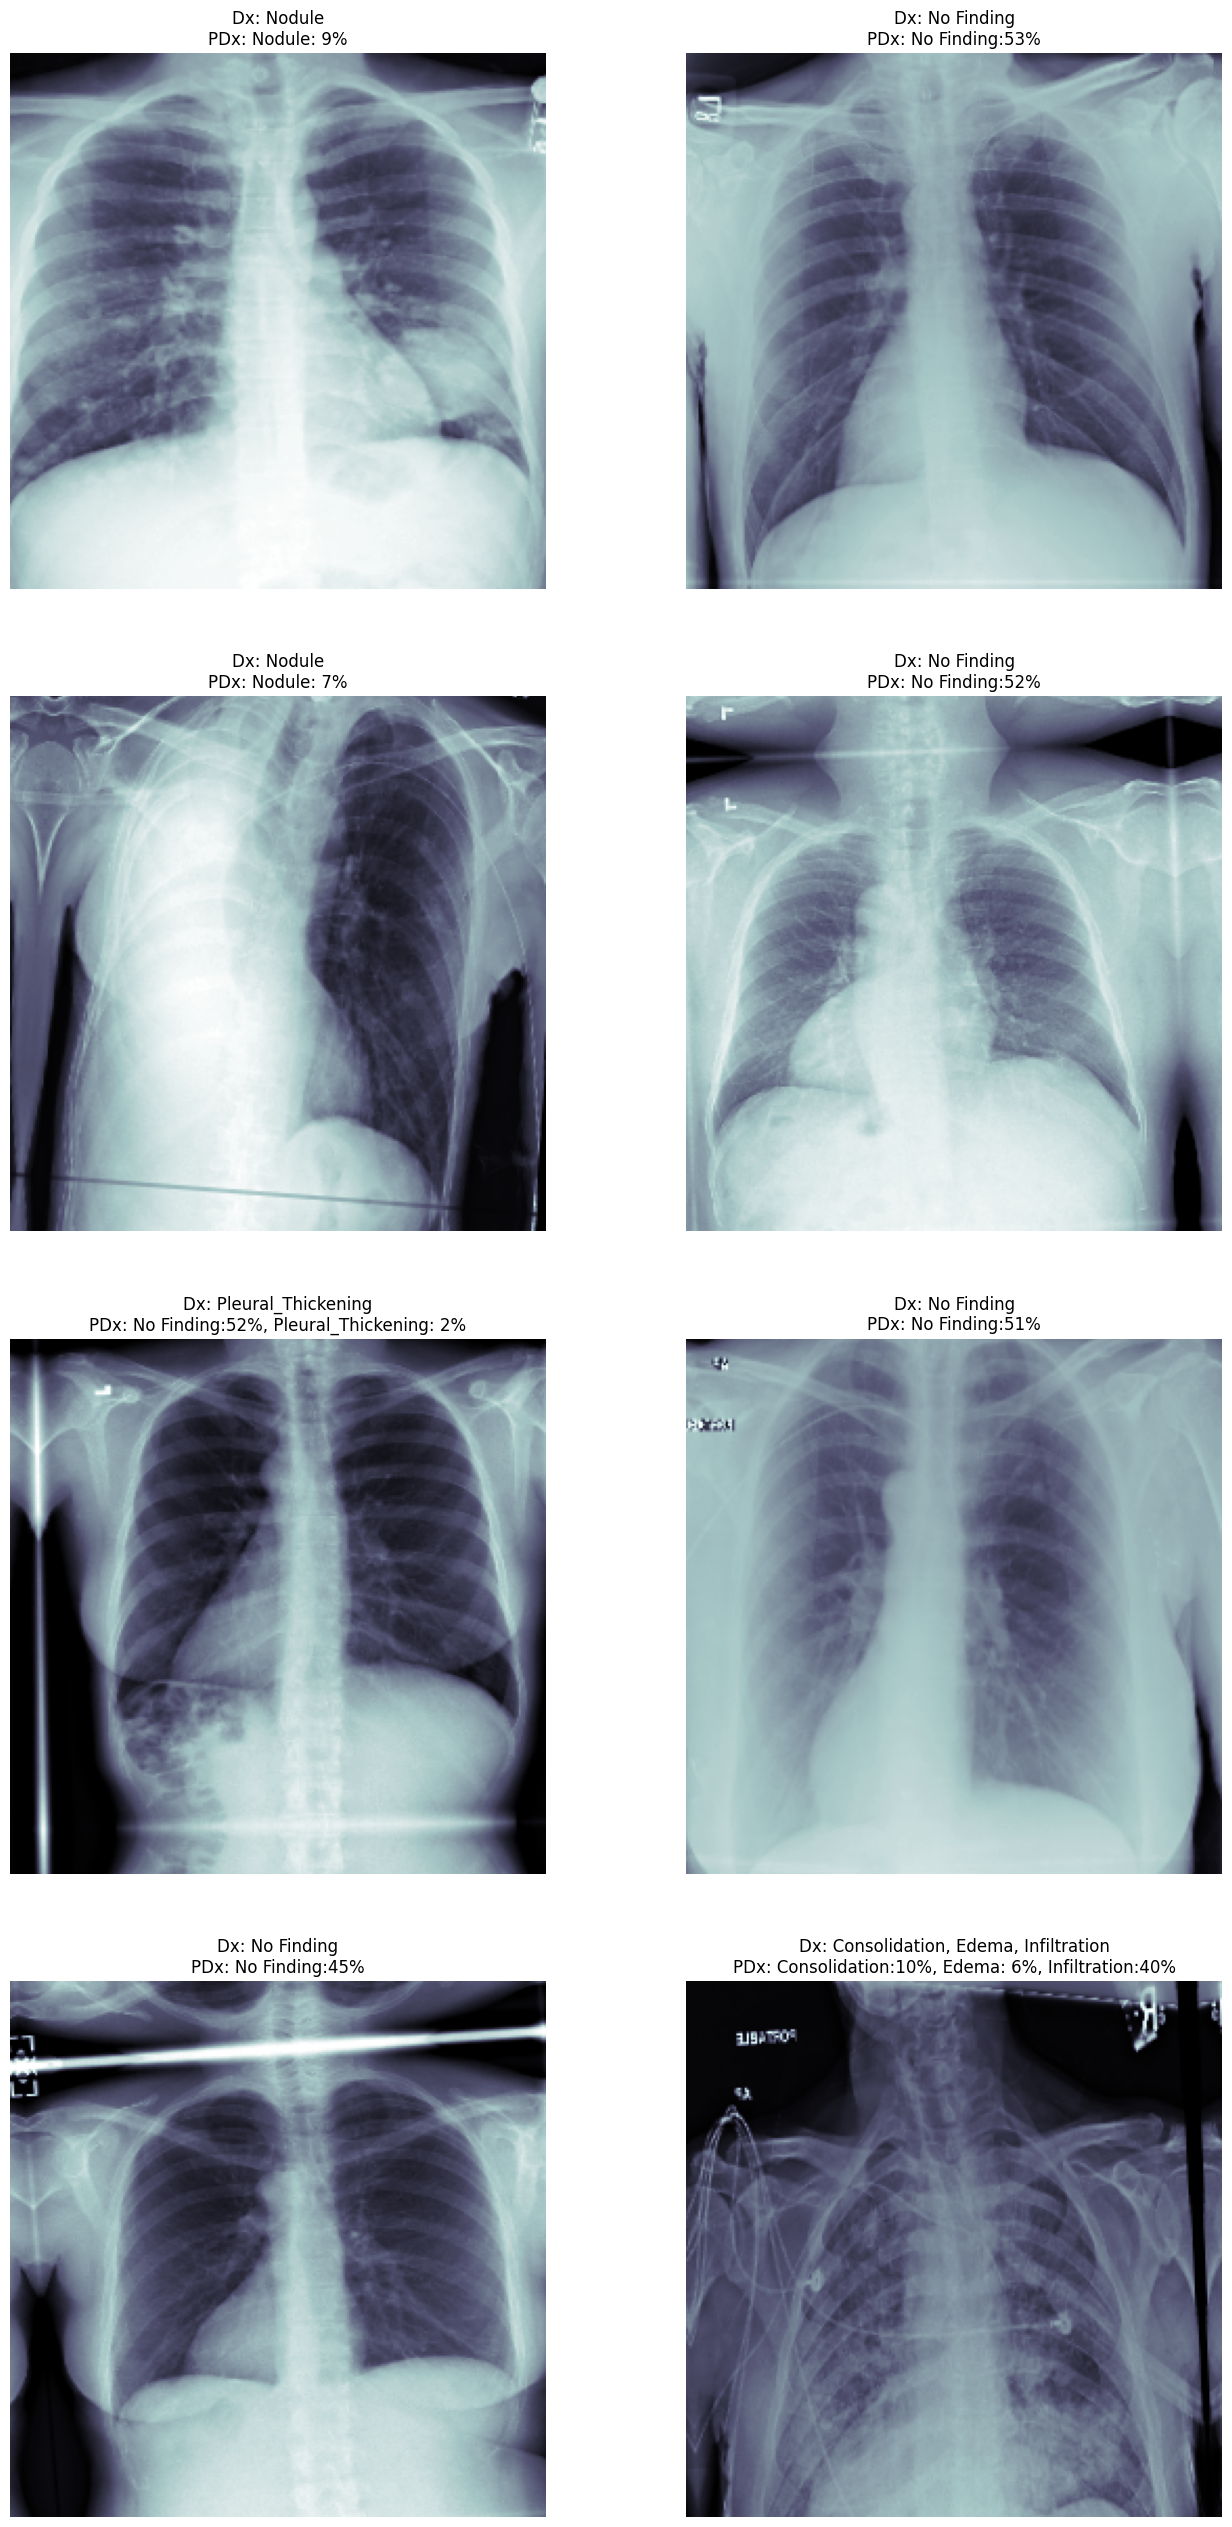

In [14]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class for n_class, n_score in zip(labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class, p_score*100)  for n_class, n_score, p_score in zip(labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

In [15]:
test_loss, test_accuracy, test_mae = multi_disease_model.evaluate(test_X, test_Y)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test MAE: {test_mae}")

23/23 [==============================] - 1s 40ms/step - loss: 0.2964 - binary_accuracy: 0.8892 - mae: 0.1654
Test Loss: 0.2964053153991699, Test Accuracy: 0.8892390727996826, Test MAE: 0.1654055118560791


Testing Mobilenet model on augmented images

In [21]:
aug_df = pd.read_csv(os.path.join(data_folder, "augmented_image_paths.csv"))
aug_image_paths =   {os.path.basename(x): x for x in
                      glob(os.path.join(data_folder, 'Final Augmented Images', '*.png'))}
aug_df['path'] = aug_df['File name'].map(aug_image_paths.get)
aug_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [24]:
aug_gen = core_idg.flow_from_dataframe(dataframe=aug_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 128) # we can use much larger batches for evaluation

aug_X, aug_Y = next(core_idg.flow_from_dataframe(dataframe=aug_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 294))

Found 294 validated image filenames belonging to 12 classes.
Found 294 validated image filenames belonging to 12 classes.


In [25]:
aug_loss, aug_accuracy, aug_mae = multi_disease_model.evaluate(aug_X, aug_Y)
print(f"Test Loss: {aug_loss}, Test Accuracy: {aug_accuracy}, Test MAE: {aug_mae}")

10/10 [==============================] - 1s 48ms/step - loss: 0.3548 - binary_accuracy: 0.8778 - mae: 0.1797
Test Loss: 0.35480988025665283, Test Accuracy: 0.8778344988822937, Test MAE: 0.17966638505458832


In [27]:
aug_pred_Y = multi_disease_model.predict(aug_X, batch_size = 64, verbose = True)

5/5 [==============================] - 1s 142ms/step


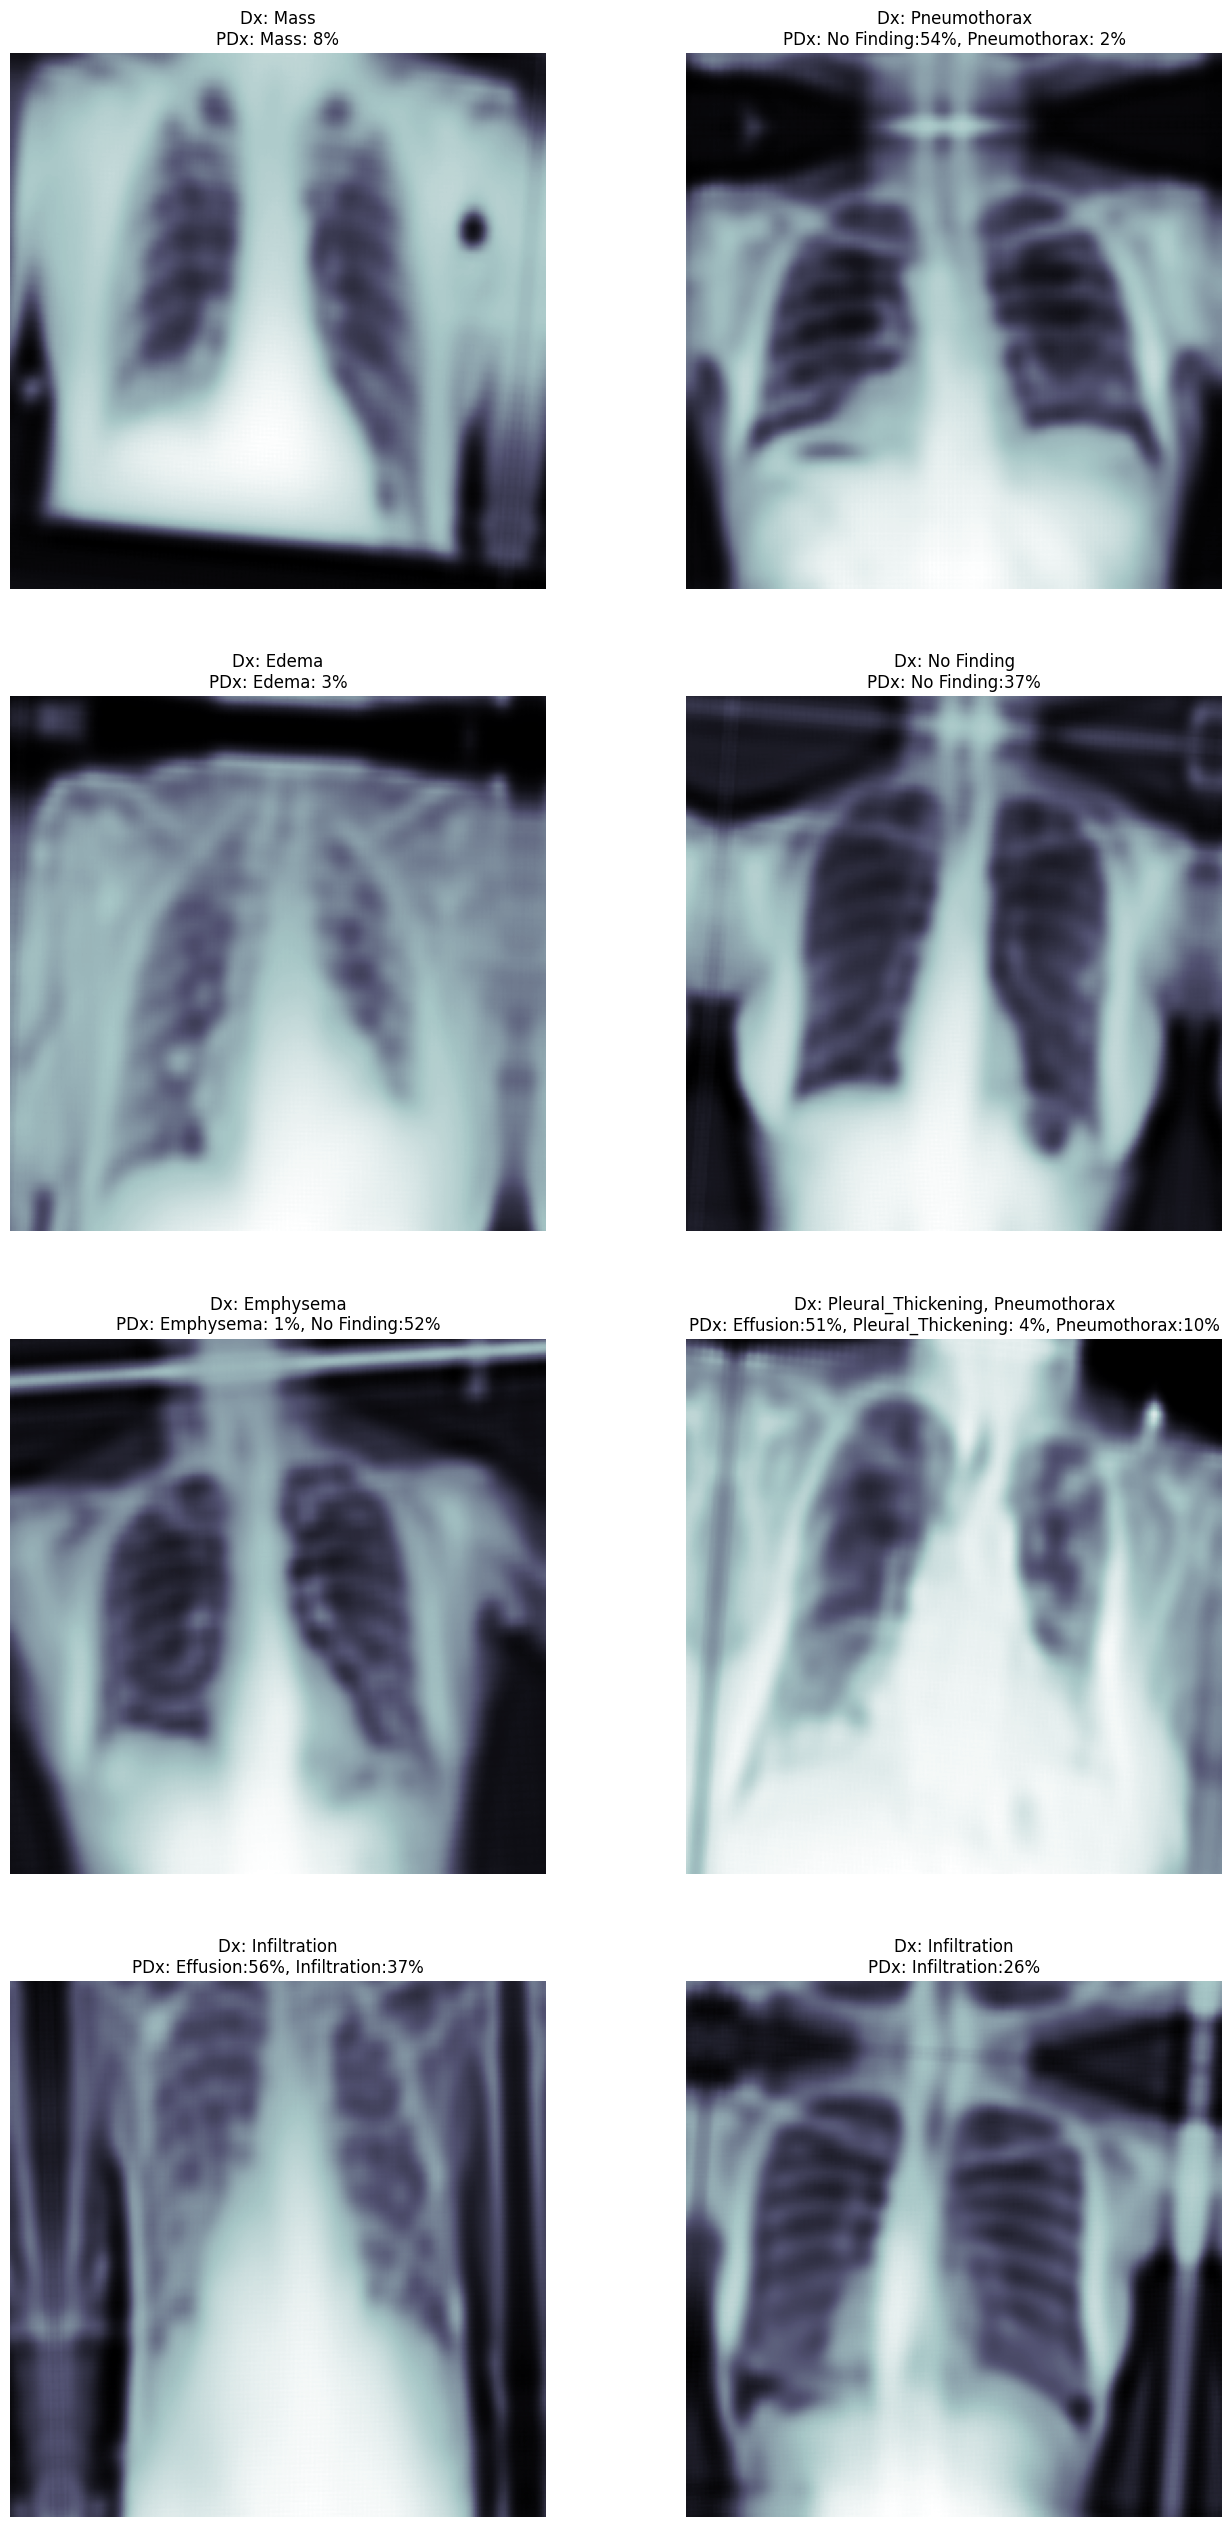

In [30]:
sickest_idx = np.argsort(np.sum(aug_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(aug_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class for n_class, n_score in zip(labels, 
                                                                  aug_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class, p_score*100)  for n_class, n_score, p_score in zip(labels, 
                                                                  aug_Y[idx], aug_pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')